# CSC420: Assignment 4

## Humzah Khan

## Imports

In [2]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Question 4: Homography (60)

## Question 5: Mean Shift Tracking

Upload Mbappe Video

In [3]:
from google.colab import files

uploaded = files.upload()

Saving KylianMbappe.mp4 to KylianMbappe (1).mp4


Detect face in the first frame with Viola-Jones

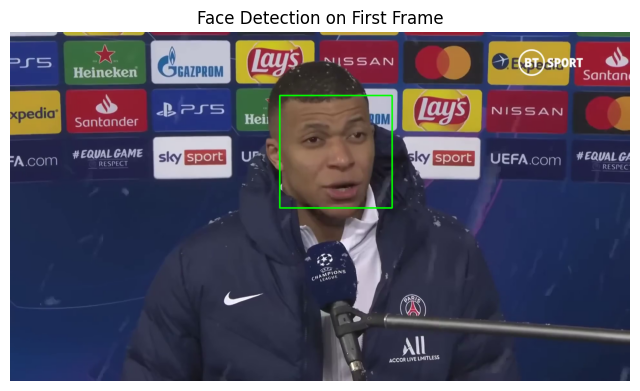

In [4]:
# Load the Haar Cascade for face detection (Viola-Jones algorithm)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the video
video_path = "KylianMbappe.mp4"
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()
cap.release()  # Close the video capture

if ret:
    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    # Draw bounding boxes around detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Green box

    # Convert BGR to RGB for displaying in Matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the result
    plt.figure(figsize=(8, 6))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title("Face Detection on First Frame")
    plt.show()
else:
    print("Error: Could not read video file.")


Create histogram

In [5]:
# Convert frame to HSV
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# Extract the face region
(x, y, w, h) = faces[0]  # Use the first detected face
face_roi = hsv_frame[y:y+h, x:x+w]

# Create a mask based on saturation and value thresholds
lower_bound = np.array([0, 60, 32])  # Low saturation & value are ignored
upper_bound = np.array([180, 255, 255])
mask = cv2.inRange(face_roi, lower_bound, upper_bound)

# Compute the Hue Histogram
hist = cv2.calcHist([face_roi], [0], mask, [180], [0, 180])
cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)  # Normalize

# Save the tracking window
track_window = (x, y, w, h)


In [14]:
# Reopen the video
cap = cv2.VideoCapture(video_path)

# Skip the first frame (since we already processed it)
ret, frame = cap.read()

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    # Convert frame to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Compute back projection using the Hue Histogram
    back_proj = cv2.calcBackProject([hsv_frame], [0], hist, [0, 180], 1)

    # Apply Mean Shift to find the new location
    ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))

    # Draw the tracking box
    x, y, w, h = track_window
    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue box for tracking

    # Convert BGR to RGB for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the tracking frame
    #plt.imshow(frame_rgb)
    #plt.axis("off")
    #plt.pause(0.03)  # Pause for smooth animation

cap.release()
#plt.show()


IoU with Viola-Jones

In [15]:
def calculate_iou(boxA, boxB):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.

    Args:
    - boxA, boxB: (x, y, w, h) format

    Returns:
    - IoU score (float between 0 and 1)
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute intersection area
    intersection = max(0, xB - xA) * max(0, yB - yA)

    # Compute areas of both bounding boxes
    areaA = boxA[2] * boxA[3]
    areaB = boxB[2] * boxB[3]

    # Compute union
    union = areaA + areaB - intersection

    # Avoid division by zero
    if union == 0:
        return 0.0

    return intersection / union


In [16]:
# Load Viola-Jones Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Reopen video
cap = cv2.VideoCapture(video_path)

# Skip the first frame (since we already processed it)
ret, frame = cap.read()

frame_count = 1  # Start from frame 1
iou_values = []  # Store IoU values
frame_numbers = []  # Store frame numbers

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    frame_count += 1  # Increment frame number

    # Convert frame to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Compute back projection using the Hue Histogram
    back_proj = cv2.calcBackProject([hsv_frame], [0], hist, [0, 180], 1)

    # Apply Mean Shift to update tracking
    ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))

    # Get bounding box from Mean Shift
    x, y, w, h = track_window

    # Convert frame to grayscale for Viola-Jones
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect face using Viola-Jones
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        detected_face = faces[0]  # Take the first detected face
        iou = calculate_iou(track_window, detected_face)
        iou_values.append(iou)
        frame_numbers.append(frame_count)

cap.release()


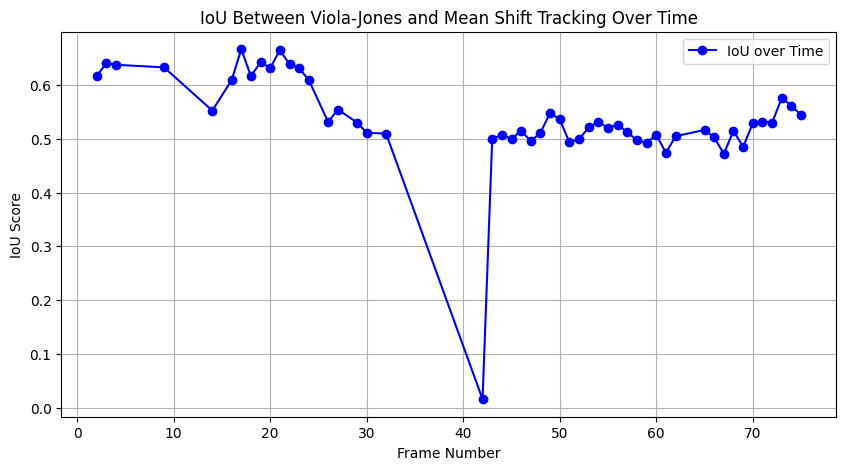

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(frame_numbers, iou_values, marker='o', linestyle='-', color='b', label="IoU over Time")
plt.xlabel("Frame Number")
plt.ylabel("IoU Score")
plt.title("IoU Between Viola-Jones and Mean Shift Tracking Over Time")
plt.legend()
plt.grid(True)
plt.show()


IoU Above 50% Match

In [22]:
# Calculate the percentage of frames where IoU > 50%
iou_threshold = 0.5
num_frames_above_threshold = sum(1 for iou in iou_values if iou > iou_threshold)
total_frames = len(iou_values)

# Compute the percentage
percentage_above_threshold = (num_frames_above_threshold / 75) * 100

print(f"Percentage of frames where IoU > 50%: {percentage_above_threshold:.2f}%")


Percentage of frames where IoU > 50%: 53.33%


Frame 17 (above 50%) and Frame 42 (below 10%)

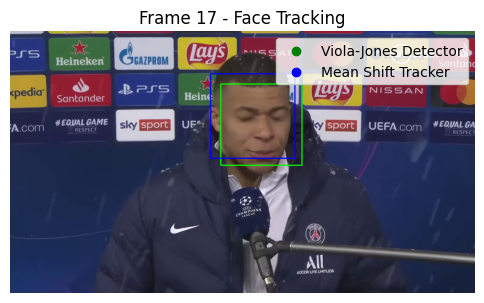

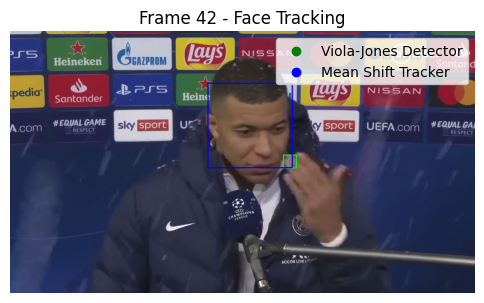

In [10]:
# Reopen video
cap = cv2.VideoCapture(video_path)

# Define the target frames
target_frames = [17, 42]
frames_to_display = {}

frame_count = 1  # Start from frame 1

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    if frame_count in target_frames:
        # Convert to HSV for Mean Shift
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        back_proj = cv2.calcBackProject([hsv_frame], [0], hist, [0, 180], 1)
        ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))
        tracked_box = track_window  # (x, y, w, h)

        # Convert to grayscale for Viola-Jones
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

        if len(faces) > 0:
            detected_face = faces[0]  # Take the first detected face

            # Draw bounding boxes
            x, y, w, h = detected_face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Green (Viola-Jones)

            x, y, w, h = tracked_box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue (Mean Shift)

            # Store the frame
            frames_to_display[frame_count] = frame

    frame_count += 1

cap.release()

# Display frames 17 and 42
for frame_number in target_frames:
    if frame_number in frames_to_display:
        frame_rgb = cv2.cvtColor(frames_to_display[frame_number], cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(frame_rgb)
        plt.axis("off")
        plt.title(f"Frame {frame_number} - Face Tracking")

        # Create legend
        plt.scatter([], [], color='green', label="Viola-Jones Detector")
        plt.scatter([], [], color='blue', label="Mean Shift Tracker")
        plt.legend()

        plt.show()


### **Discussion**

The Mean Shift tracker appears to perform better than the Viola-Jones detector overall in the Mbappe video because following the color histogram, is making the object detection more resilient to occlusions and smoother over time. In contrast, Viola-Jones applies frame-by-frame detection, meaning it can misclassify background objects or transient features (like a hand or nail) as faces, leading to sudden errors. Mean Shift’s reliance on histogram back-projection appears to allow it to stay focused on the tracked object, even when part of the face is temporarily blocked. Assuming at least the first frame was correctly identifying the object to get it's histogram.

### A Simple Variation (Hog)

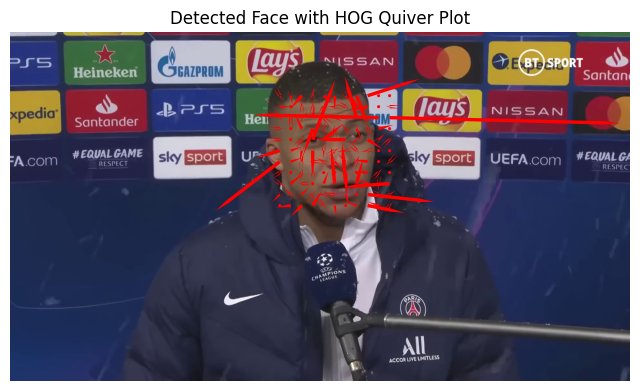

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if ret:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect face using Viola-Jones
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        x, y, w, h = faces[0]  # First detected face

        # Apply Gaussian Blur to reduce noise
        gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Compute image gradients using Sobel operator
        grad_x = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=3)

        # Convert gradients to magnitude & direction (in degrees)
        mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

        # Extract the face region
        face_roi_angle = angle[y:y+h, x:x+w]
        face_roi_mag = mag[y:y+h, x:x+w]

        # Compute max gradient magnitude inside face ROI
        max_mag = np.max(face_roi_mag)
        threshold = 0.02 * max_mag  # Threshold for keeping strong gradients
        mask = (face_roi_mag > threshold).astype(np.uint8)  # Create binary mask
        #mask = (mask < (1-threshold)).astype(np.uint8)

        # Downsample the grid for quiver plotting
        step = max(1, w // 10)  # Adjust step size for reasonable arrow density
        X, Y = np.meshgrid(np.arange(x, x + w, step), np.arange(y, y + h, step))

        # Extract gradient directions at sampled points
        sampled_angles = face_roi_angle[::step, ::step]
        sampled_mags = face_roi_mag[::step, ::step]

        # Convert angles to radians for quiver plotting
        U = np.cos(np.deg2rad(sampled_angles)) * sampled_mags
        V = np.sin(np.deg2rad(sampled_angles)) * sampled_mags

        # Normalize arrow sizes for better visibility
        scale_factor = h / 1000  # Scale arrows relative to face height
        U /= scale_factor
        V /= scale_factor

        # Convert frame to RGB for plotting
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Plot the face with gradient quiver arrows
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(frame_rgb)
        ax.axis("off")
        ax.set_title("Detected Face with HOG Quiver Plot")

        # Draw green bounding box around detected face
        cv2.rectangle(frame_rgb, (x, y), (x + w, y + h), (0, 255, 0), 3)

        # Overlay quiver plot inside the detected face
        ax.quiver(X, Y, U, V, color="red", angles="xy", scale_units="xy", scale=1, headlength=0, headwidth=0)

        plt.show()

    else:
        print("No face detected in the first frame.")

else:
    print("Error: Could not read video file.")


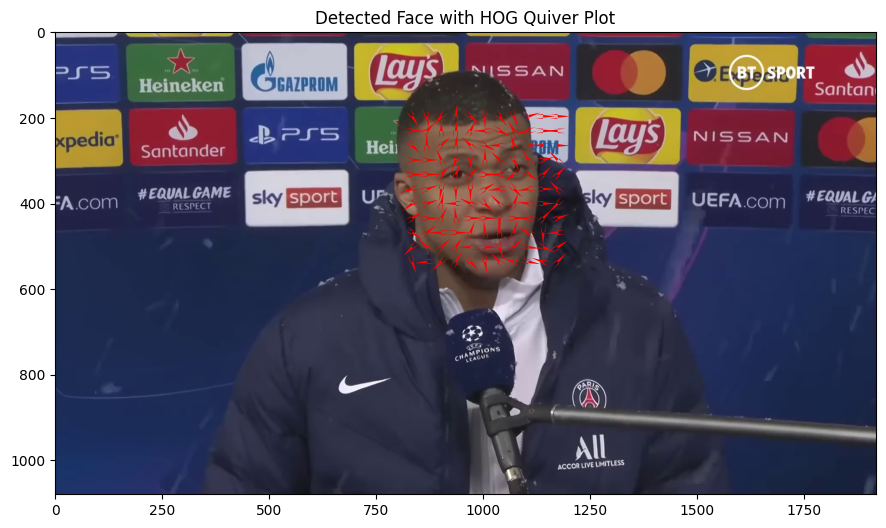

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if ret:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect face using Viola-Jones
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        x, y, w, h = faces[0]  # First detected face

        # Apply Gaussian Blur to reduce noise
        gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Compute image gradients using Sobel operator
        grad_x = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=3)

        # Convert gradients to magnitude & direction (in degrees)
        mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

        # Extract the face region
        face_roi_angle = angle[y:y+h, x:x+w]
        face_roi_mag = mag[y:y+h, x:x+w]

        # Compute frequency-based histogram (no magnitude weighting)
        hist_bins = 24
        hist_range = [0, 360]
        hist = cv2.calcHist([face_roi_angle], [0], None, [hist_bins], hist_range)  # No mask, no magnitude weighting

        # Normalize histogram for better visualization
        hist = hist / np.sum(hist)  # Normalize to sum to 1

        # Downsample the grid for quiver plotting
        step = max(1, w // 10)  # Adjust step size for reasonable arrow density
        X, Y = np.meshgrid(np.arange(x, x + w, step), np.arange(y, y + h, step))

        # Extract gradient directions at sampled points
        sampled_angles = face_roi_angle[::step, ::step]
        sampled_mags = face_roi_mag[::step, ::step]

        # Convert angles to radians for quiver plotting
        U = np.cos(np.deg2rad(sampled_angles))
        V = np.sin(np.deg2rad(sampled_angles))

        # Normalize arrow sizes for better visibility
        scale_factor = h / 10000  # Adjust scaling to make arrows visible
        U /= scale_factor
        V /= scale_factor

        # Convert frame to RGB for plotting
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Create figure with two subplots (face detection + histogram)
        fig, ax = plt.subplots( figsize=(12, 6))

        # Show the face with detected bounding box and quiver arrows
        ax.imshow(frame_rgb)
        #ax[0].axis("off")
        ax.set_title("Detected Face with HOG Quiver Plot")

        # Draw green bounding box around detected face
        cv2.rectangle(frame_rgb, (x, y), (x + w, y + h), (0, 255, 0), 3)

        # Overlay quiver plot inside the detected face
        ax.quiver(X, Y, U, V, color="red", angles="xy", scale_units="xy", scale=1, headlength=0, headwidth=0)

        # ## Plot Frequency-Based HOG Histogram
        # ax[1].bar(np.linspace(0, 360, hist_bins), hist.flatten(), width=15, color='b', edgecolor='black')
        # ax[1].set_xlim(0, 360)
        # ax[1].set_xticks(np.arange(0, 361, 45))
        # ax[1].set_xlabel("Gradient Direction (Degrees)")
        # ax[1].set_ylabel("Frequency (Normalized)")
        # ax[1].set_title("Frequency-Based Gradient Histogram for Detected Face")

        #plt.tight_layout()
        plt.show()

    else:
        print("No face detected in the first frame.")

else:
    print("Error: Could not read video file.")


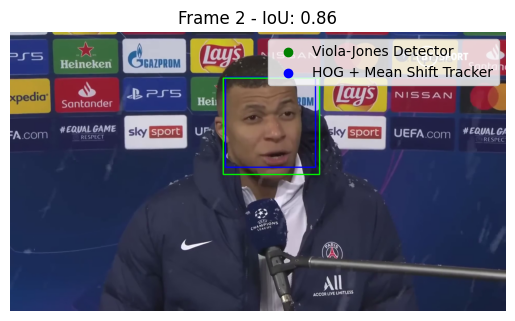

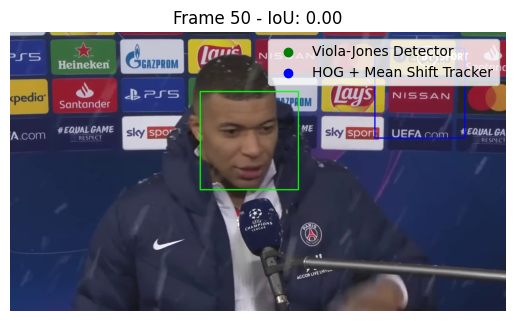

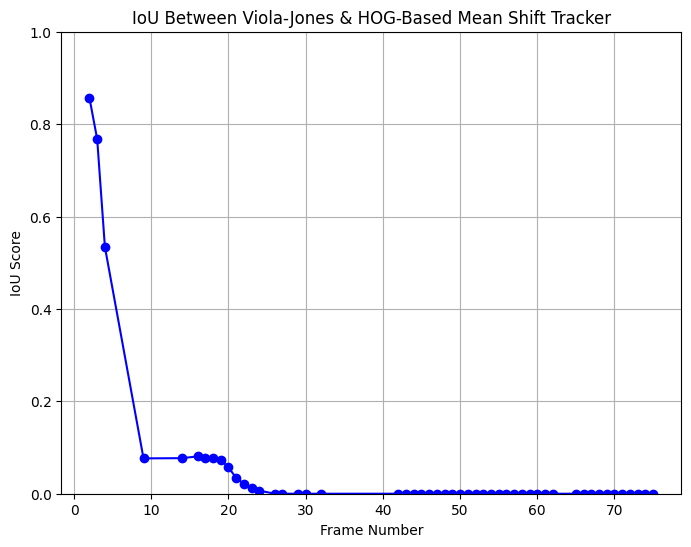

Percentage of frames where IoU > 50%: 4.00%


In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_iou(boxA, boxB):
    """Computes Intersection over Union (IoU) between two bounding boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute intersection area
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute individual box areas
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    # Compute IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Load video
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()
if not ret:
    print("Error: Could not read video file.")
    cap.release()
    exit()

# Convert first frame to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect face in first frame using Viola-Jones
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

if len(faces) > 0:
    x, y, w, h = faces[0]  # First detected face
    track_window = (x, y, w, h)  # Initialize tracking window

    # Apply Gaussian Blur
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Compute image gradients using Sobel operator
    grad_x = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=5)

    # Convert gradients to magnitude & direction (in degrees)
    mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    # Extract face region
    face_roi_angle = angle[y:y+h, x:x+w]
    face_roi_mag = mag[y:y+h, x:x+w]

    # Compute frequency-based histogram (no magnitude weighting)
    hist_bins = 24
    hist_range = [0, 360]
    hist = cv2.calcHist([face_roi_angle], [0], None, [hist_bins], hist_range)  # No mask, no magnitude weighting

    # Normalize histogram for tracking
    hist = hist / np.sum(hist)

else:
    print("No face detected in the first frame.")
    cap.release()
    exit()

# Store IoU values
iou_values = []
frame_numbers = []

# Process the rest of the video using Mean Shift Tracking
frame_count = 1

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    frame_count += 1

    # Convert to grayscale and blur
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Compute gradients
    grad_x = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=3)

    # Convert to magnitude and direction
    mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    # Compute back projection using frequency-based HOG histogram
    back_proj = cv2.calcBackProject([angle], [0], hist, [0, 360], 1)

    # Apply Mean Shift to track the face
    ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))

    # Get Viola-Jones detection in the current frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    check = 0

    if len(faces) > 0:
        vx, vy, vw, vh = faces[0]  # Take first detected face
        viola_jones_box = (vx, vy, vw, vh)

        # Compute IoU between Mean Shift and Viola-Jones
        iou = compute_iou(track_window, viola_jones_box)
        iou_values.append(iou)
        frame_numbers.append(frame_count)

        check = 1

    #print(iou_values)

    if frame_count == 50 or frame_count == 2:


        # Draw bounding boxes
        x, y, w, h = track_window
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue box for Mean Shift

        if check == 1:
            cv2.rectangle(frame, (vx, vy), (vx + vw, vy + vh), (0, 255, 0), 3)  # Green box for Viola-Jones

        # Convert BGR to RGB for display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the tracking frame
        plt.imshow(frame_rgb)
        plt.axis("off")
        if check == 1:
          plt.title(f"Frame {frame_count} - IoU: {iou:.2f}")
        else:
          plt.title(f"Frame {frame_count} - IoU: 0")
        # Create legend
        plt.scatter([], [], color='green', label="Viola-Jones Detector")
        plt.scatter([], [], color='blue', label="HOG + Mean Shift Tracker")
        plt.legend()
        plt.pause(0.01)  # Pause for smooth animation

cap.release()
plt.show()

# ** Plot IoU over time **
plt.figure(figsize=(8, 6))
plt.plot(frame_numbers, iou_values, marker="o", linestyle="-", color="b")
plt.xlabel("Frame Number")
plt.ylabel("IoU Score")
plt.title("IoU Between Viola-Jones & HOG-Based Mean Shift Tracker")
plt.ylim(0, 1)
plt.grid()
plt.show()

# ** Print percentage of frames with IoU > 50% **
above_50 = sum(1 for i in iou_values if i > 0.5) / frame_count * 100
print(f"Percentage of frames where IoU > 50%: {above_50:.2f}%")
